# Proyecto Final - Pronosticar para Transformar
Jorge Guijarro - A01563113

In [ ]:
# Importar librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.plotting import lag_plot, autocorrelation_plot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

In [ ]:
# Cargar el CSV 
df = pd.read_csv('per-capita-co-emissions_united-kingdom.csv')

# Renombrar la columna de emisiones
df.rename(
    columns={'Annual CO₂ emissions (per capita)': 'emissions_per_capita'},
    inplace=True
)

# Estructura resultante
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entity                174 non-null    object 
 1   Year                  174 non-null    int64  
 2   emissions_per_capita  174 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


,Entity,Year,emissions_per_capita
0,United Kingdom,1850,4.489172
1,United Kingdom,1851,4.252994
2,United Kingdom,1852,4.215993
3,United Kingdom,1853,4.167399
4,United Kingdom,1854,4.991562


## Análisis Exploratorio de los Datos

== Valores faltantes por columna ==
Entity                  0
Year                    0
emissions_per_capita    0
z_score                 0
outlier                 0
dtype: int64 

== Estadísticas descriptivas ==
count    174.000000
mean       9.089763
std        1.928904
min        4.167399
25%        8.155690
50%        9.716547
75%       10.438251
max       11.815786
Name: emissions_per_capita, dtype: float64 

== Valores atípicos (|Z| > 3) ==
Empty DataFrame
Columns: [Entity, Year, emissions_per_capita, z_score, outlier]
Index: [] 

== Valores atípicos (método IQR) ==
             Entity  Year  emissions_per_capita   z_score  outlier
0    United Kingdom  1850              4.489172 -2.391964    False
1    United Kingdom  1851              4.252994 -2.514759    False
2    United Kingdom  1852              4.215993 -2.533996    False
3    United Kingdom  1853              4.167399 -2.559262    False
5    United Kingdom  1855              4.645776 -2.310541    False
8    United Kingdom

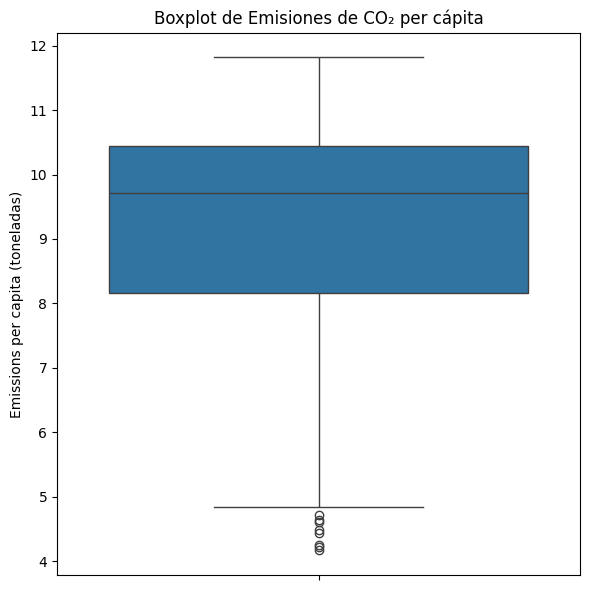

In [ ]:
# Revisión de datos faltantes
print("== Valores faltantes por columna ==")
print(df.isna().sum(), "\n")

# Estadísticas descriptivas
print("== Estadísticas descriptivas ==")
print(df['emissions_per_capita'].describe(), "\n")

# Detección de outliers con Z-score
zs = stats.zscore(df['emissions_per_capita'].dropna())
abs_zs = np.abs(zs)
threshold = 3
outlier_idxs = df['emissions_per_capita'].dropna().index[abs_zs > threshold]
print(f"== Valores atípicos (|Z| > {threshold}) ==")
print(df.loc[outlier_idxs], "\n")

# Detección de outliers con IQR
Q1 = df['emissions_per_capita'].quantile(0.25)
Q3 = df['emissions_per_capita'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[
    (df['emissions_per_capita'] < Q1 - 1.5 * IQR) |
    (df['emissions_per_capita'] > Q3 + 1.5 * IQR)
]
print("== Valores atípicos (método IQR) ==")
print(outliers_iqr, "\n")

# Boxplot 
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['emissions_per_capita'])
plt.title('Boxplot de Emisiones de CO₂ per cápita')
plt.ylabel('Emissions per capita (toneladas)')
plt.tight_layout()
plt.show()


## Primera visualización de la serie de tiempo

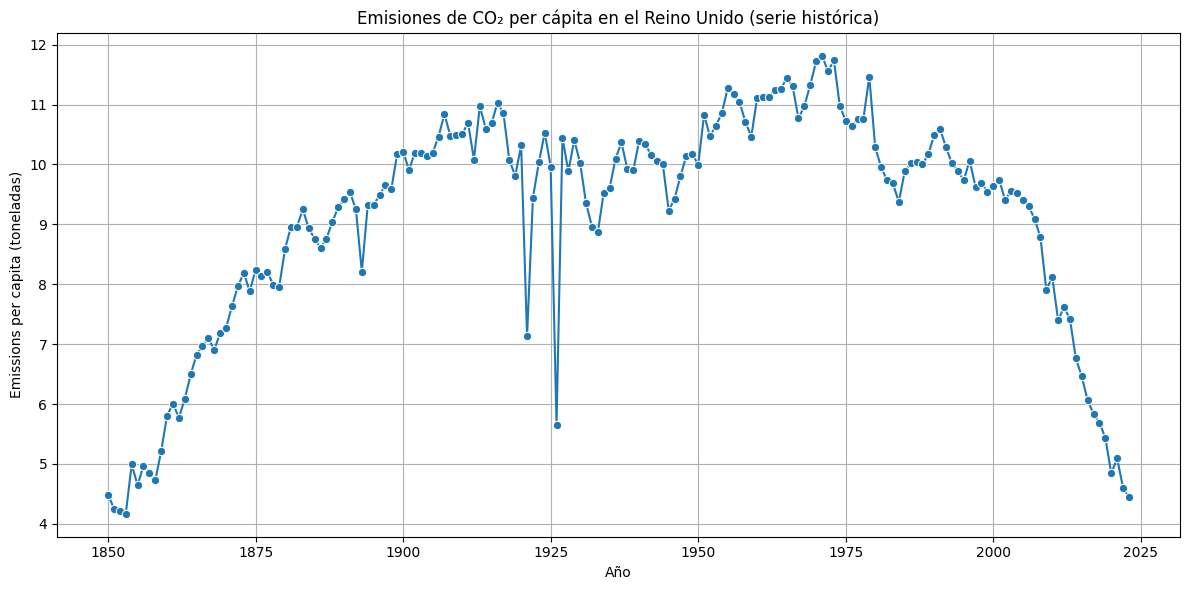

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='emissions_per_capita', marker='o')
plt.title('Emisiones de CO₂ per cápita en el Reino Unido (serie histórica)')
plt.xlabel('Año')
plt.ylabel('Emissions per capita (toneladas)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Estructura de la serie de tiempo

Convertimos la serie en una serie con índice de fechas anuales, y aplica una descomposición aditiva con un periodo de 10 años para analizar sus tres componentes principales: la tendencia, la estacionalidad y el error

Tendencia: muestra un claro descenso en emisiones per cápita desde mediados del siglo XX hasta la actualidad

Estacionalidad: es prácticamente nula o muy débil

Residuo: Se caputuran las fluctuaciones año a año, no se muestra ningún patrón consistente

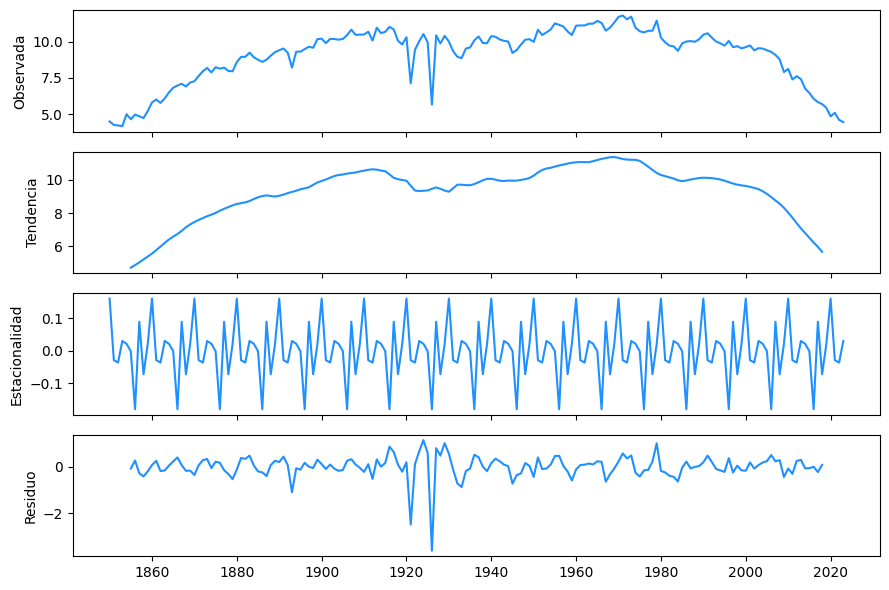

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Preparar la serie temporal con índice datetime
serie = df.set_index('Year')['emissions_per_capita']
serie.index = pd.to_datetime(serie.index.astype(str), format='%Y')
serie = serie.asfreq('YS')  # frecuencia anual

# Descomposición
decomposition = seasonal_decompose(serie, model='additive', period=10)

# Graficar componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(9,6))

ax1.plot(decomposition.observed, color='dodgerblue')
ax1.set_ylabel('Observada')

ax2.plot(decomposition.trend, color='dodgerblue')
ax2.set_ylabel('Tendencia')

ax3.plot(decomposition.seasonal, color='dodgerblue')
ax3.set_ylabel('Estacionalidad')

ax4.plot(decomposition.resid, color='dodgerblue')
ax4.set_ylabel('Residuo')

plt.tight_layout()
plt.show()


## Visualizar ACF y PACF. Prueba aumentada de Dickey-Fuller

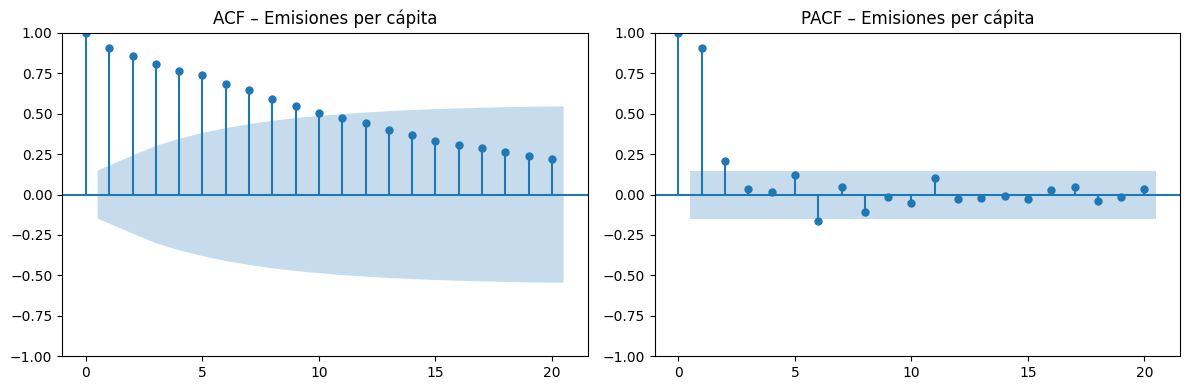

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Preparar la serie
ts = df.set_index('Year')['emissions_per_capita'].dropna()

# Graficar ACF y PACF 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ts, lags=20, ax=axes[0])
axes[0].set_title('ACF – Emisiones per cápita')

plot_pacf(ts, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF – Emisiones per cápita')

plt.tight_layout()
plt.show()


In [ ]:
# Prueba aumentada de Dickey–Fuller
adf_stat, p_value, used_lag, n_obs, crit_values, icbest = adfuller(ts)
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {p_value:.4f}")
for level, cv in crit_values.items():
    print(f"Crit. value ({level}): {cv:.4f}")

ADF Statistic: -1.4702
p-value: 0.5482
Crit. value (1%): -3.4709
Crit. value (5%): -2.8793
Crit. value (10%): -2.5763


La ACF muestra una caída lenta, característica de series no estacionarias.

La PACF tampoco presenta un corte claro tras un rezago fijo, lo que descarta de inicio un modelo puramente MA(q) o AR(p) en la serie sin transformaciones.

Además, tampoco observamos ruido blanco, lo que descarta una caminata aleatoria.

La prueba ADF arroja un p-value mayor a 0.05 (no rechazamos 𝐻0), confirmando la presencia de raíz unitaria y la no estacionariedad.

Ahora que descartamos estos modelos simples, Diferenciamos  la serie para eliminar la tendencia y convertirla en estacionaria.

Volvemos a graficar ACF y PACF sobre la serie diferenciada

## Elección del modelo

ADF diff Stat: -2.5851   p-value: 0.0961
  Crit. value (1%): -3.4709
  Crit. value (5%): -2.8793
  Crit. value (10%): -2.5763


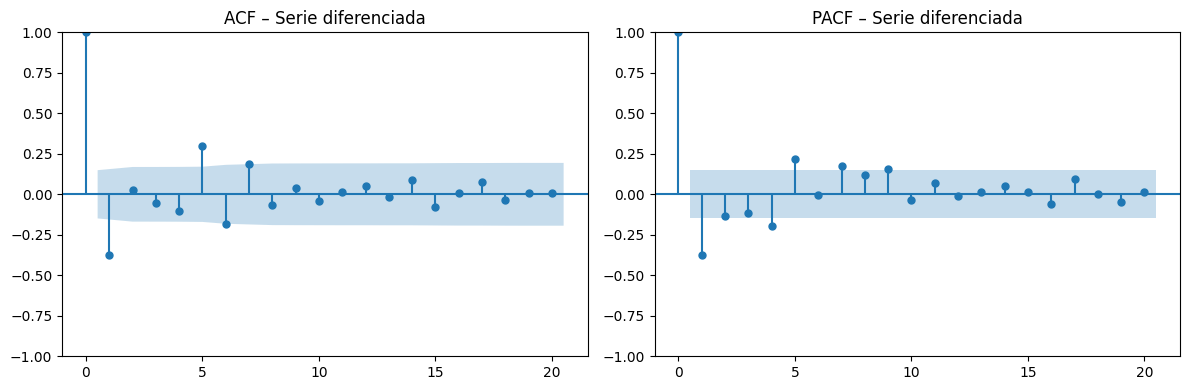

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Diferenciar la serie (d=1)
ts_diff = ts.diff().dropna()

# Prueba ADF sobre la serie diferenciada
adf_stat_d, p_value_d, _, _, crit_values_d, _ = adfuller(ts_diff)
print(f"ADF diff Stat: {adf_stat_d:.4f}   p-value: {p_value_d:.4f}")
for lvl, cv in crit_values_d.items():
    print(f"  Crit. value ({lvl}): {cv:.4f}")

# Graficar ACF y PACF de la serie diferenciada
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF – Serie diferenciada')
plot_pacf(ts_diff, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF – Serie diferenciada')
plt.tight_layout()
plt.show()


Ahora, se aplicó una diferenciación de orden 1 para remover la tendencia y luego se verificó con la prueba ADF que la nueva serie es estacionaria. Finalmente, se reconstruyeron los gráficos de ACF y PACF sobre la serie diferenciada.

La ACF presenta un corte abrupto tras el rezago 1, lo que sugiere que un ARMA(1,1) o ARIMA (1,1,1) sobre la serie diferenciada es un modelo plausible.

Además, decidimos descartar SARIMA ya que no existe estacionalidad y no daría mejores resultados.

### Metodología de Box-Jenkins

Antes de continuar con dicho modelo, utilzaremos la metodología de Box-Jenkins para verificar que modelo sería el ideal

In [ ]:
# Probar todas las combinaciones de p y q (d=1)
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
q_values = [0, 1, 2, 3, 4, 5, 6, 7]
results = []

for p in p_values:
    for q in q_values:
        try:
            m = ARIMA(ts, order=(p, 1, q)).fit()
            results.append((p, q, m.aic))
        except:
            continue

# Seleccionar el mejor modelo con AIC más bajo
df_aic = pd.DataFrame(results, columns=['p', 'q', 'AIC']).sort_values('AIC')
best_p, best_q = df_aic.iloc[0][['p','q']]

# Ajustar el modelo
best_model = ARIMA(ts, order=(best_p, 1, best_q)).fit()

# Diagnóstico de residuos
resid = best_model.resid

# Resultados
df_aic = pd.DataFrame(results, columns=['p', 'q', 'AIC']) \
    .sort_values(by='AIC') \
    .reset_index(drop=True)
df_aic




c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\s

,p,q,AIC
0,2,6,316.791426
1,5,3,316.802644
2,1,5,317.039061
3,5,2,317.534828
4,6,2,317.543926
...,...,...,...
59,2,0,335.226401
60,3,1,335.490915
61,1,0,336.488740
62,2,2,336.640151


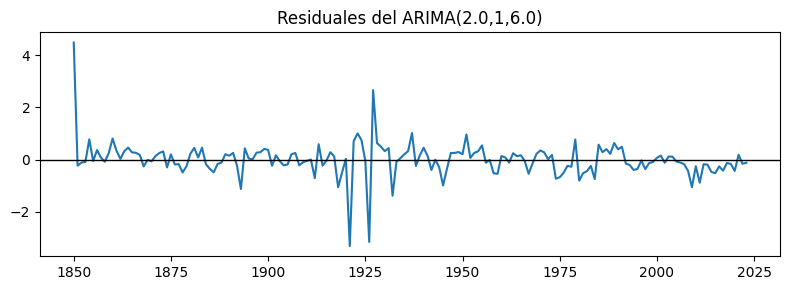

<Figure size 600x300 with 0 Axes>

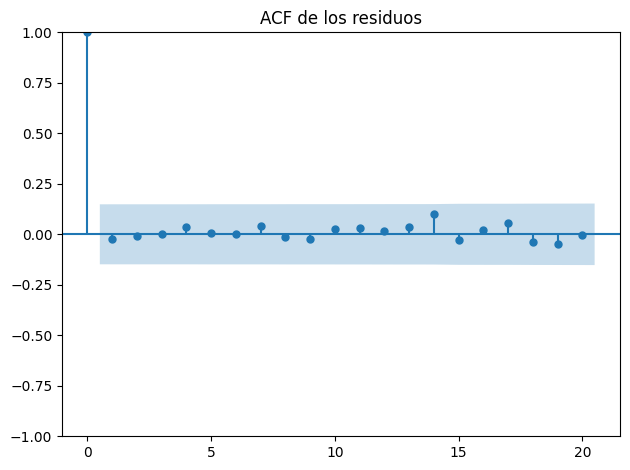

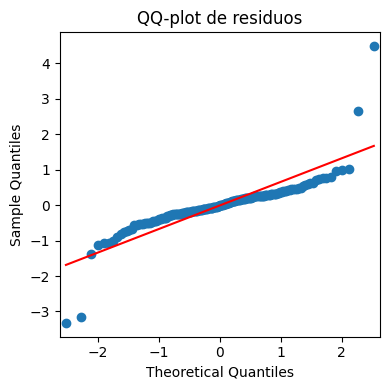

Ljung–Box p-values (lags 1–10):
 1     0.754085
2     0.948284
3     0.991041
4     0.986326
5     0.996264
6     0.999118
7     0.998438
8     0.999505
9     0.999787
10    0.999895
Name: lb_pvalue, dtype: float64


In [ ]:
# Residuos con el tiempo
plt.figure(figsize=(8,3))
plt.plot(resid)
plt.axhline(0, color='black', lw=1)
plt.title('Residuales del ARIMA({},1,{})'.format(best_p, best_q))
plt.tight_layout()
plt.show()

# ACF de residuos
plt.figure(figsize=(6,3))
plot_acf(resid, lags=20)
plt.title('ACF de los residuos')
plt.tight_layout()
plt.show()

# Q-plot de los residuos
plt.figure(figsize=(4,4))
qqplot(resid, line='s', ax=plt.gca())
plt.title('QQ-plot de residuos')
plt.tight_layout()
plt.show()

# Prueba de Ljung–Box
lb = acorr_ljungbox(resid, lags=list(range(1,11)), return_df=True)
print("Ljung–Box p-values (lags 1–10):\n", lb['lb_pvalue'])


Vemos que el modelo que mejor se ajusta es un ARIMA(2,1,6)

## Evaluación del Modelo ARIMA(2,1,6)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# División de los datos (80% train, 20% test)
split_idx = int(len(ts) * 0.8)
train, test = ts.iloc[:split_idx], ts.iloc[split_idx:]

# Ajuste del modelo
model_tt = ARIMA(train, order=(2, 1, 6)).fit()

# Pronóstico sobre el test set
pred = model_tt.forecast(steps=len(test))

# Cálculo de métricas de precisión
mae  = mean_absolute_error(test, pred)
mape = mean_absolute_percentage_error(test, pred) * 100
rmse = np.sqrt(np.mean((pred - test)**2))

print(f"MAE:  {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.3f}")


c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE:  1.463
MAPE: 24.76%
RMSE: nan


c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Predicciones

In [ ]:
ts = ts.asfreq('Y')

# Reajustar el modelo ARIMA(2,1,6) sobre toda la serie ya indexada
model = ARIMA(ts, order=(2, 1, 6)).fit()

# Generar pronóstico a 3 años no observados
fc = model.get_forecast(steps=3)
forecast = fc.predicted_mean
ci       = fc.conf_int(alpha=0.05)

# Mostrar tabla de pronóstico con sus IC
pd.concat([forecast.rename('forecast'), ci], axis=1)

C:\Users\jorge\AppData\Local\Temp\ipykernel_5936\3481623870.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = ts.asfreq('Y')


,forecast,lower emissions_per_capita,upper emissions_per_capita
2024-12-31,4.264016,3.144276,5.383755
2025-12-31,4.028735,2.753119,5.304351
2026-12-31,3.980319,2.598541,5.362097


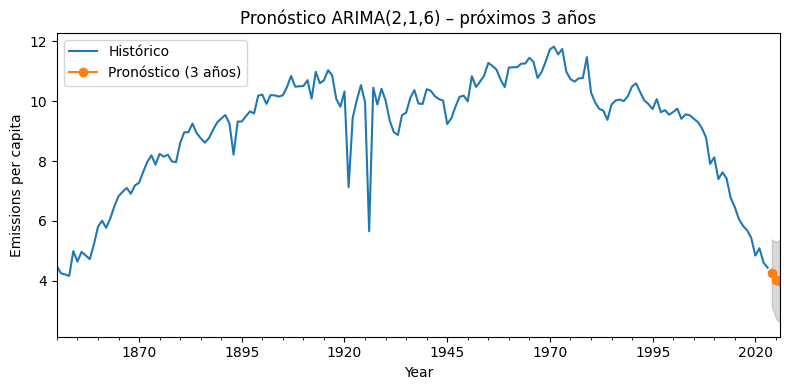

In [ ]:
# Graficar histórico + pronóstico
ax = ts.plot(label='Histórico', figsize=(8, 4))
forecast.plot(ax=ax, label='Pronóstico (3 años)', marker='o')
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3)
ax.set_title('Pronóstico ARIMA(2,1,6) – próximos 3 años')
ax.set_ylabel('Emissions per capita')
ax.legend()
plt.tight_layout()
plt.show()


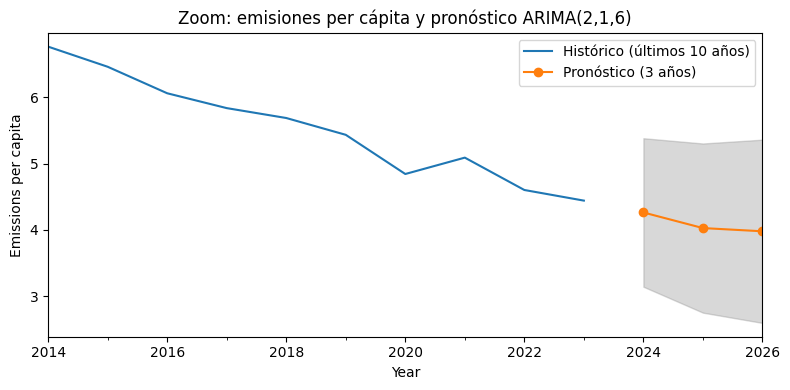

In [ ]:
# Definir cuántos años históricos queremos mostrar (por ejemplo, últimos 10 años)
zoom_years = 10
zoom_start = ts.index[-zoom_years]

# Graficar solo desde zoom_start hasta el final del pronóstico
ax = ts.loc[zoom_start:].plot(label=f'Histórico (últimos {zoom_years} años)', figsize=(8,4))
forecast.plot(ax=ax, label='Pronóstico (3 años)', marker='o')

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3)

ax.set_xlim(zoom_start, ci.index[-1])
ax.set_title('Zoom: emisiones per cápita y pronóstico ARIMA(2,1,6)')
ax.set_ylabel('Emissions per capita')
ax.legend()
plt.tight_layout()
plt.show()
